In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from cobra.io import read_sbml_model
from cobra import Reaction, Metabolite
from cobra.util import create_stoichiometric_matrix
from cobra.medium import minimal_medium
from cameo import models
from cameo.visualization.plotting.with_plotly import PlotlyPlotter
import numpy as np
import escher

import cobra.test
from cobra.flux_analysis import production_envelope

In [2]:
model = read_sbml_model('model_yeast8_rhb.xml') # insert model HERE

In [121]:
for metabolites in model.metabolites.query('BIOMASS','id'):
    print(reactions.id)

In [124]:
for reactions in model.reactions.query('BIOMASS_yeast-GEM','id'):
    print(reactions.id)

BIOMASS_yeast-GEM_LIP
BIOMASS_yeast-GEM
BIOMASS_yeast-GEM_PROT
BIOMASS_yeast-GEM_CARB
BIOMASS_yeast-GEM_RNA
BIOMASS_yeast-GEM_DNA
BIOMASS_yeast-GEM_LIPBACK
BIOMASS_yeast-GEM_LIPCHAIN
BIOMASS_yeast-GEM_COFACTOR
BIOMASS_yeast-GEM_ION


In [125]:
model.reactions.get_by_id('BIOMASS_yeast-GEM')

Reaction identifier,BIOMASS_yeast-GEM
Name,biomass pseudoreaction
Memory address,0x015611b6a128
Stoichiometry,55.3 atp_c + carbohydrate_c + cofactor_c + dna_c + 55.3 h2o_c + ion_c + lipid_c + protein_c + rna_c --> 55.3 adp_c + biomass_c + 55.3 h_c + 55.3 pi_c 55.3 ATP + carbohydrate + cofactor + DNA + 55.3 H2O + ion + lipid + protein + RNA --> 55.3 ADP + biomass + 55.3 H+ + 55.3 phosphate
GPR,
Lower bound,0.0
Upper bound,1000.0


In [6]:
model.reactions.rHb.metabolites


{<Metabolite ala__L_c at 0x1560ff79668>: -72.0,
 <Metabolite cys__L_c at 0x1560ff846a0>: -6.0,
 <Metabolite asp__L_c at 0x1560ff7ec50>: -30.0,
 <Metabolite glu__L_c at 0x1560ff8b048>: -24.0,
 <Metabolite phe__L_c at 0x1560ff95f98>: -30.0,
 <Metabolite gly_c at 0x1560ff8be80>: -40.0,
 <Metabolite his__L_c at 0x1560ff91390>: -38.0,
 <Metabolite lys__L_c at 0x1560ff957f0>: -44.0,
 <Metabolite leu__L_c at 0x1560ff95358>: -72.0,
 <Metabolite met__L_c at 0x1560ff95c50>: -10.0,
 <Metabolite asn__L_c at 0x1560ff7e7f0>: -20.0,
 <Metabolite pro__L_c at 0x1560ff9b320>: -28.0,
 <Metabolite gln__L_c at 0x1560ff8bac8>: -8.0,
 <Metabolite arg__L_c at 0x1560ff7e400>: -12.0,
 <Metabolite ser__L_c at 0x1560ff9b940>: -32.0,
 <Metabolite thr__L_c at 0x1560ffa2128>: -32.0,
 <Metabolite val__L_c at 0x1560ffa2d68>: -62.0,
 <Metabolite trp__L_c at 0x1560ffa2518>: -6.0,
 <Metabolite tyr__L_c at 0x1560ffa27f0>: -12.0,
 <Metabolite pheme_m at 0x1560ff210f0>: -4.0,
 <Metabolite rHb_c at 0x156102cc9e8>: 1.0}

# The composition of the medium

Let's look at the default media composition

In [60]:
model.medium

{'EX_nh4_e': 1000.0,
 'EX_glc__D_e': 10.0,
 'EX_h_e': 1000.0,
 'EX_fe2_e': 1000.0,
 'EX_o2_e': 1000.0,
 'EX_pi_e': 1000.0,
 'EX_k_e': 1000.0,
 'EX_na1_e': 1000.0,
 'EX_so4_e': 1000.0,
 'EX_h2o_e': 1000.0,
 'EX_cl_e': 1000.0,
 'EX_cu2_e': 1000.0,
 'EX_mn2_e': 1000.0,
 'EX_zn2_e': 1000.0,
 'EX_mg2_e': 1000.0,
 'EX_ca2_e': 1000.0}

In [63]:
model.reactions.EX_ac_e

Reaction identifier,EX_ac_e
Name,acetate exchange
Memory address,0x0156117faf28
Stoichiometry,ac_e --> acetate -->
GPR,
Lower bound,0.0
Upper bound,1000.0


**Template:**

In [64]:
medium = model.medium
#model.add_boundary(model.metabolites.pheme_m, type='demand') # adds the exchange reaction for heme
with model:
    solution = model.optimize()
    print("Standard yeast maximum theoretical biomass productivity:", solution.fluxes['BIOMASS_yeast-GEM'], '/h')
    model.medium = medium
    model.objective = model.reactions.rHb
    heme_production = model.optimize().objective_value
    print("Maximum theoretical productivity of heme", heme_production, '[mmol gDW^-1 h^-1]')
    print("Maximum theoretical yield of rHb:", heme_production / (-1 * model.reactions.EX_glc__D_e.flux), "[mmol-rHb / mmol-glucose]")

Standard yeast maximum theoretical biomass productivity: 0.8637367930478773 /h
Maximum theoretical productivity of heme 0.016333900695118374 [mmol gDW^-1 h^-1]
Maximum theoretical yield of rHb: 0.0016333900695118374 [mmol-rHb / mmol-glucose]


In [ ]:
with model:
    solution = model.optimize()
    print("Standard yeast maximum theoretical biomass productivity:", solution.fluxes['BIOMASS_yeast-GEM'], '/h')
    model.medium = medium
    model.objective = model.reactions.rHb
    heme_production = model.optimize().objective_value
    print("Maximum theoretical productivity of heme", heme_production, '[mmol gDW^-1 h^-1]')
    print("Maximum theoretical yield of rHb:", heme_production / (-1 * model.reactions.EX_glc__D_e.flux), "[mmol-rHb / mmol-glucose]")

# Optimizing growth and heme production at varying glucose concentrations

In [9]:
%%time
medium = model.medium
#model.add_boundary(model.metabolites.pheme_m, type='demand') # adds the exchange reaction for heme
x = [] #list to hold biomass values
y = [] #list to hold  hemoglobin values
tx = [] #list to hold time values for biomass
ty = [] #list to hold time values for hemoglobin
i = 0 #Counter
with model:
    while i < 1000: #Optimizes growth for increasing glucose values and stores values in vector x.
        medium['EX_glc__D_e'] = i
        tx.append(i) #Adds glucose concentration to a list
        model.medium = medium
        solution = model.optimize()
        #print("Standard yeast maximum theoretical biomass productivity:", solution.fluxes['BIOMASS_SC5_notrace'], '/h')
        x.append(solution.fluxes['BIOMASS_yeast-GEM']) #may need to adjust biomass name depending on model
        i = i + 25

    #print(x)
    #print(medium['EX_glc__D_e'])
    i = 0   
    while i < 1000: #Optimizes heme prod for increasing glucose values and stores values in vector y.
        medium['EX_glc__D_e'] = i
        ty.append(i) #adds glucose concentration to a list
        model.medium = medium
        model.objective = model.reactions.rHb #redirect to acctua hemoglobin reaction
        heme_production = model.optimize().objective_value
        #print("Standard yeast maximum theoretical productivity of heme ", heme_production, '[mmol gDW^-1 h^-1]')
        y.append(heme_production)
        i = i + 25
    #print(y)
    #brug evt: ny_vector = np.array(y) #siden "y" er en liste kan det maaske give problemer naar der skal plottes. Det her laver det np.array

C:\Users\Rasso\anaconda3\envs\carveme_env\lib\site-packages\cobra\util\solver.py:554: UserWarning:

Solver status is 'infeasible'.

C:\Users\Rasso\anaconda3\envs\carveme_env\lib\site-packages\cobra\util\solver.py:554: UserWarning:

Solver status is 'infeasible'.



Wall time: 4.83 s


In [108]:
o_bio = []
to_bio = []
o_rhb =[]
to_rhb = []
i = 0
with model:
    while i < 13: #Optimizes growth for increasing glucose values and stores values in vector x.
        medium['EX_o2_e'] = i
        to_bio.append(i) #Adds glucose concentration to a list
        model.medium = medium
        solution = model.optimize()
        #print("Standard yeast maximum theoretical biomass productivity:", solution.fluxes['BIOMASS_SC5_notrace'], '/h')
        o_bio.append(solution.fluxes['BIOMASS_yeast-GEM']) #may need to adjust biomass name depending on model
        i = i + 1
        
    i = 0.08   
    while i < 13: #Optimizes heme prod for increasing glucose values and stores values in vector y.
        medium['EX_glc__D_e'] = i
        to_rhb.append(i) #adds glucose concentration to a list
        model.medium = medium
        model.objective = model.reactions.rHb #redirect to acctua hemoglobin reaction
        heme_production = model.optimize().objective_value
        #print("Standard yeast maximum theoretical productivity of heme ", heme_production, '[mmol gDW^-1 h^-1]')
        o_rhb.append(heme_production)
        i = i + 1

Text(0, 0.5, 'Theoretical biomass productivity')

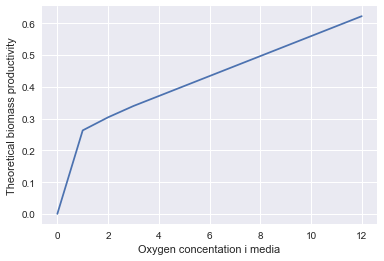

In [109]:
o_bio = np.array(o_bio)
to_bio = np.array(to_bio)
plt.plot(to_bio,o_bio)
plt.xlabel("Oxygen concentation i media")
plt.ylabel("Theoretical biomass productivity")

Text(0, 0.5, 'Theoretical rHb productivity')

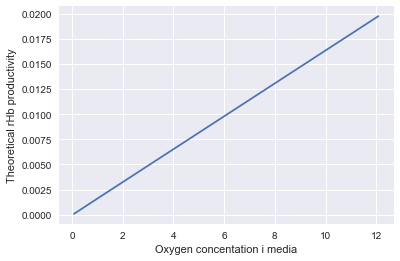

In [110]:
o_rhb = np.array(o_rhb)
to_rhb = np.array(to_rhb)
plt.plot(to_rhb,o_rhb)
plt.xlabel("Oxygen concentation i media")
plt.ylabel("Theoretical rHb productivity")

In [13]:
z_bio = []
tz_bio = []
z_rhb = []
tz_rhb = []
i = 0 
with model:
    while i < 1000: #Optimizes growth for increasing glucose values and stores values in vector x.
        medium['EX_fe2_e'] = i
        tz_bio.append(i) #Adds glucose concentration to a list
        model.medium = medium
        solution = model.optimize()
        #print("Standard yeast maximum theoretical biomass productivity:", solution.fluxes['BIOMASS_SC5_notrace'], '/h')
        z_bio.append(solution.fluxes['BIOMASS_yeast-GEM']) #may need to adjust biomass name depending on model
        i = i + 25

    #print(x)
    #print(medium['EX_glc__D_e'])
    i = 0 
    while i < 1000: #Optimizes heme prod for increasing glucose values and stores values in vector y.
        medium['EX_fe2_e'] = i
        tz_rhb.append(i) #adds glucose concentration to a list
        model.medium = medium
        model.objective = model.reactions.rHb #redirect to acctual hemoglobin reaction
        heme_production = model.optimize().objective_value
        #print("Standard yeast maximum theoretical productivity of heme ", heme_production, '[mmol gDW^-1 h^-1]')
        z_rhb.append(heme_production)
        i = i + 25

The growth- and prod values are stored in lists x and y respectively

In [16]:
x = np.array(x)
tx = np.array(tx)
y = np.array(y)
tz = np.array(ty)
z_bio = np.array(z_bio)
tz_bio = np.array(tz_bio)
z_rhb = np.array(z_rhb)
tz_rhb = np.array(tz_rhb)

In [17]:
print(len(tx),len(tz),len(ty))

40 40 40


Text(0, 0.5, 'Theoretical biomass productivity')

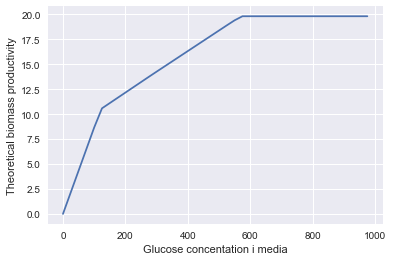

In [18]:
plt.plot(tx,x)
plt.xlabel("Glucose concentation i media")
plt.ylabel("Theoretical biomass productivity")

Text(0, 0.5, 'Theoretical hemoglobin productivity')

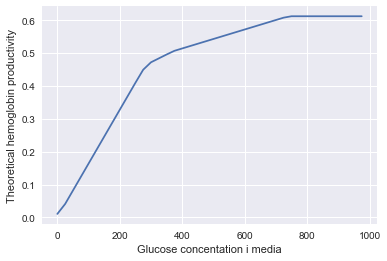

In [19]:
plt.plot(ty,y)
plt.xlabel("Glucose concentation i media")
plt.ylabel("Theoretical hemoglobin productivity")

Text(0, 0.5, 'Theoretical biomass productivity')

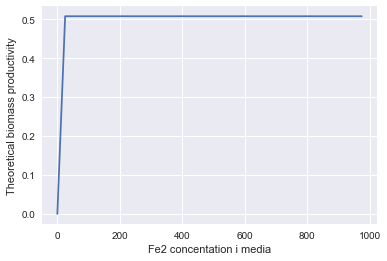

In [20]:
plt.plot(tz_bio,z_bio)
plt.xlabel("Fe2 concentation i media")
plt.ylabel("Theoretical biomass productivity")

Text(0, 0.5, 'Theoretical hemoglobin productivity')

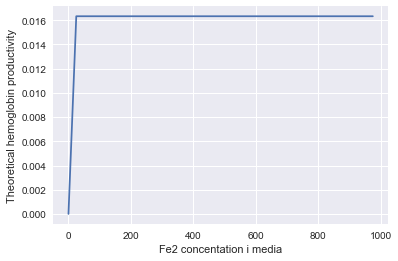

In [21]:
plt.plot(tz_rhb,z_rhb)
plt.xlabel("Fe2 concentation i media")
plt.ylabel("Theoretical hemoglobin productivity")

# Plots of Hemoglobin production and growth

<function matplotlib.pyplot.show(close=None, block=None)>

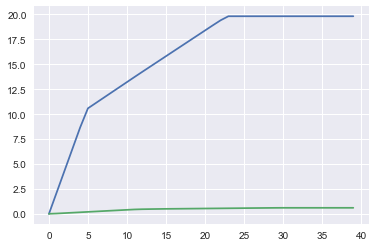

In [22]:
plt.plot(x)
plt.plot(y)
plt.show

In [112]:
from cameo.flux_analysis.analysis import phenotypic_phase_plane 
plotter = PlotlyPlotter() 
production_envelope_DW = phenotypic_phase_plane(model,  
                                             variables=[model.reactions.GROWTH], 
                                             objective=model.metabolites.rHb_c) 


0.8637367930480663


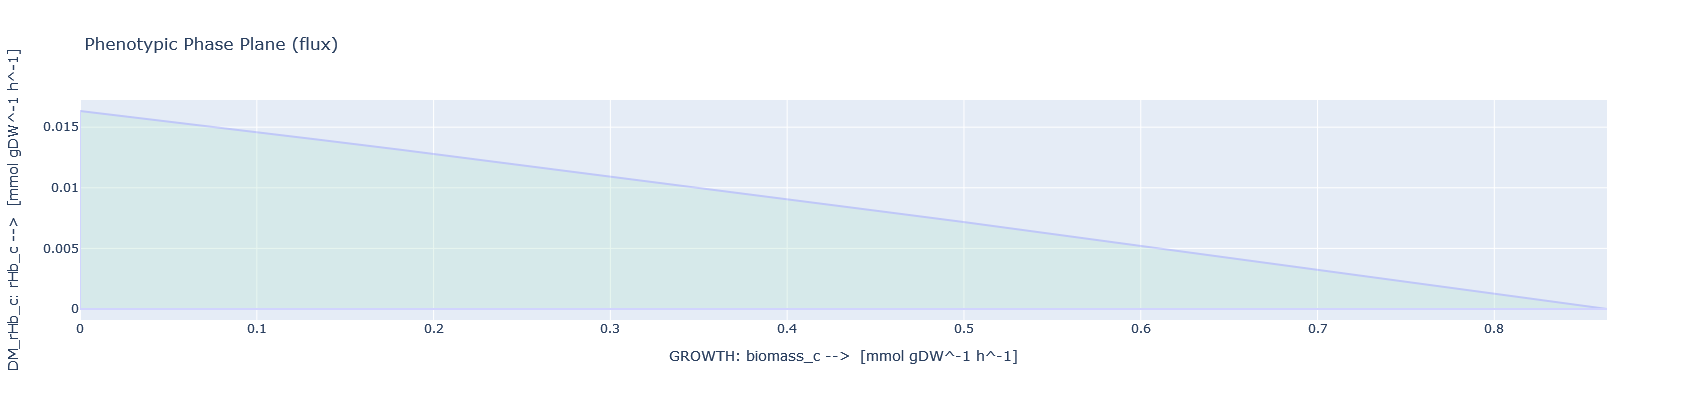

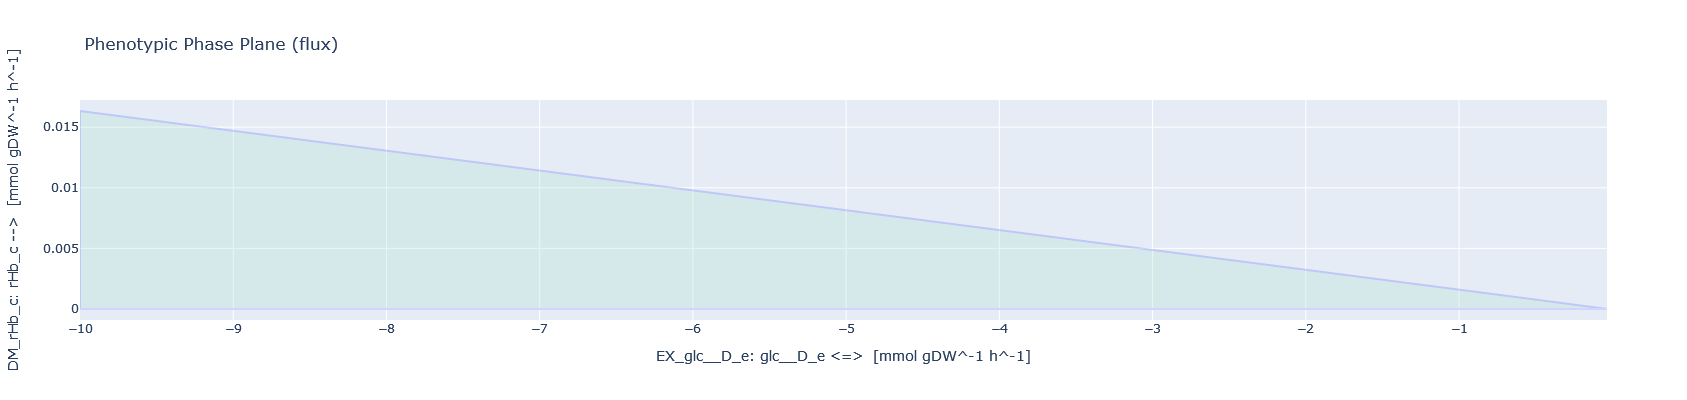

In [115]:

medium = model.medium 
with model:  
    model.medium = medium 
    solution = model.optimize() 
    print(solution.fluxes['GROWTH']) 
    production_envelope_glc = phenotypic_phase_plane(model,  
                                             variables=[model.reactions.EX_glc__D_e],#,model.reactions.EX_o2_e], 
                                             objective=model.metabolites.rHb_c) 
production_envelope_DW.plot(plotter, height=400) 
production_envelope_glc.plot(plotter, height=400) 

In [25]:
#%matplotlib inline
from cobra.flux_analysis import production_envelope #Needs to be called again for it to work..
prod_env = production_envelope(
    model, ["EX_o2_e"], objective=["rHb"], carbon_sources="EX_glc__D_e")
prod_env.head() #Shows data in table

,carbon_source,flux_minimum,carbon_yield_minimum,mass_yield_minimum,flux_maximum,carbon_yield_maximum,mass_yield_maximum,EX_o2_e
0,EX_glc__D_e,0.0,0.0,NaN,0.000000,0.000000,NaN,-60.000000
1,EX_glc__D_e,0.0,0.0,NaN,0.001005,0.049802,NaN,-56.842105
2,EX_glc__D_e,0.0,0.0,NaN,0.002009,0.099603,NaN,-53.684211
3,EX_glc__D_e,0.0,0.0,NaN,0.003014,0.149405,NaN,-50.526316
4,EX_glc__D_e,0.0,0.0,NaN,0.004019,0.199206,NaN,-47.368421


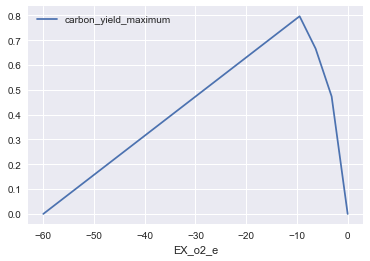

In [26]:
P1 = prod_env.plot(
    kind='line', x='EX_o2_e', y='carbon_yield_maximum');

In [27]:
prod_env = production_envelope(
    model, ["EX_o2_e"], objective='BIOMASS_yeast-GEM', carbon_sources="EX_glc__D_e")
#prod_env.head() #shows data in tabe

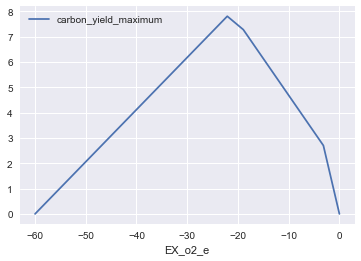

In [28]:
P2 = prod_env.plot(
    kind='line', x='EX_o2_e', y='carbon_yield_maximum');

In [29]:
prod_env = production_envelope(
    model, ["EX_glc__D_e"], objective='BIOMASS_yeast-GEM', carbon_sources="EX_glc__D_e")
#prod_env.head() #shows data in tabe

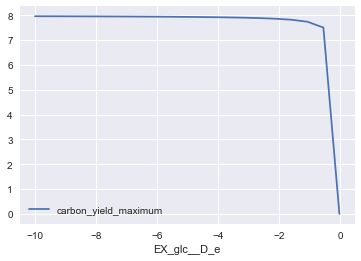

In [30]:
prod_env.plot(
    kind='line', x='EX_glc__D_e', y='carbon_yield_maximum');

In [31]:
prod_env = production_envelope(
    model, ["EX_glc__D_e"], objective="rHb", carbon_sources="EX_glc__D_e")
#prod_env.head() #shows data in tabe

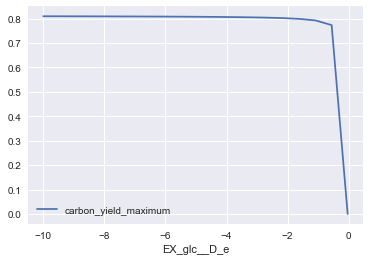

In [32]:
prod_env.plot(
    kind='line', x='EX_glc__D_e', y='carbon_yield_maximum');

In [33]:
prod_env = production_envelope(
    model, ["EX_fe2_e"], objective='BIOMASS_yeast-GEM', carbon_sources="EX_glc__D_e")
prod_env.head() #shows data in tabe

,carbon_source,flux_minimum,carbon_yield_minimum,mass_yield_minimum,flux_maximum,carbon_yield_maximum,mass_yield_maximum,EX_fe2_e
0,EX_glc__D_e,0.0,0.0,NaN,0.000000,0.000000,NaN,-0.065336
1,EX_glc__D_e,0.0,0.0,NaN,0.049031,0.451907,NaN,-0.061897
2,EX_glc__D_e,0.0,0.0,NaN,0.098063,0.903813,NaN,-0.058458
3,EX_glc__D_e,0.0,0.0,NaN,0.147094,1.355720,NaN,-0.055019
4,EX_glc__D_e,0.0,0.0,NaN,0.194602,1.793586,NaN,-0.051581


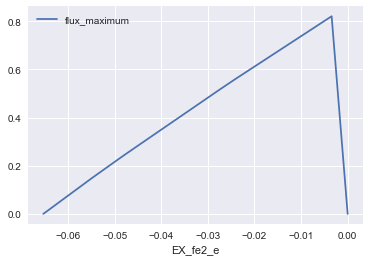

In [34]:
prod_env.plot(
    kind='line', x='EX_fe2_e', y='flux_maximum');

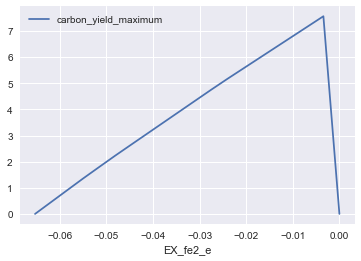

In [35]:
prod_env.plot(
    kind='line', x='EX_fe2_e', y='carbon_yield_maximum');

In [117]:
prod_env = production_envelope(
    model, ["EX_fe2_e"], objective='rHb', carbon_sources="EX_glc__D_e")
prod_env.head() #shows data in tabe

,carbon_source,flux_minimum,carbon_yield_minimum,mass_yield_minimum,flux_maximum,carbon_yield_maximum,mass_yield_maximum,EX_fe2_e
0,EX_glc__D_e,0.016334,0.809617,NaN,0.016334,0.809617,NaN,-0.065336
1,EX_glc__D_e,0.015474,0.766987,NaN,0.015474,0.809501,NaN,-0.061897
2,EX_glc__D_e,0.014614,0.724356,NaN,0.014615,0.809372,NaN,-0.058458
3,EX_glc__D_e,0.013754,0.681726,NaN,0.013755,0.809226,NaN,-0.055019
4,EX_glc__D_e,0.012894,0.639097,NaN,0.012895,0.809062,NaN,-0.051581


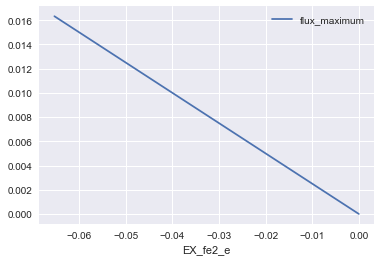

In [118]:
prod_env.plot(
    kind='line', x='EX_fe2_e', y='flux_maximum');

Trying for rHb when specifying growth instead of carbon source

In [38]:
prod_env = production_envelope(
    model, ["BIOMASS_yeast-GEM"], objective="rHb", carbon_sources="EX_glc__D_e")
#prod_env.head() #shows data in tabe

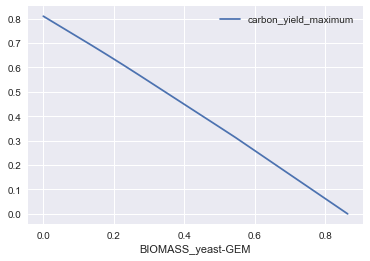

In [39]:
prod_env.plot(
    kind='line', x='BIOMASS_yeast-GEM', y='carbon_yield_maximum');

In [40]:
prod_env = production_envelope(
    model, ["rHb"], objective="BIOMASS_yeast-GEM", carbon_sources="EX_glc__D_e")
prod_env.head() #shows data in tabe

,carbon_source,flux_minimum,carbon_yield_minimum,mass_yield_minimum,flux_maximum,carbon_yield_maximum,mass_yield_maximum,rHb
0,EX_glc__D_e,0.0,0.0,NaN,0.863737,7.960774,NaN,0.000000
1,EX_glc__D_e,0.0,0.0,NaN,0.820369,7.561070,NaN,0.000860
2,EX_glc__D_e,0.0,0.0,NaN,0.777002,7.161366,NaN,0.001719
3,EX_glc__D_e,0.0,0.0,NaN,0.733634,6.761662,NaN,0.002579
4,EX_glc__D_e,0.0,0.0,NaN,0.690267,6.361958,NaN,0.003439


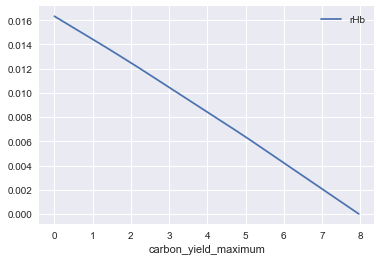

In [41]:
prod_env.plot(
    kind='line', x='carbon_yield_maximum', y='rHb'); #These axis are proberby wrong

In [42]:
with model:
    for i in range(0,10):
        model.reactions.get_by_id(df_sorted.index.values[i]).bounds = df_sorted.iloc[i,10], df_sorted.iloc[i,10]
    model.optimize()
    print('Parameters for strain with 10 upregulated targets:')
    print("Rate of heme production:", model.reactions.FCLTm.flux)
    print("Rate of hemoglobin production:", model.reactions.EX_rHb.flux)
    print("Growth rate:", model.reactions.GROWTH.flux)

    #niko says change upper and lower bound to the things we got in the matrix -> simulated up-regulated

NameError: name 'df_sorted' is not defined

# Med "slim optimize"
**in case det tager rigtig lang tid at optimere**


In [ ]:
%%time
medium = model.medium
#model.add_boundary(model.metabolites.pheme_m, type='demand') # adds the exchange reaction for heme
x = []
y = []
i = 0
with model:
    while i < 11: #Optimizes growth for increasing glucose values and stores values in vector x.
        medium['EX_glc__D_e'] = i
        model.medium = medium
        solution = model.slim_optimize()
        #print("Standard yeast maximum theoretical biomass productivity:", solution.fluxes['BIOMASS_SC5_notrace'], '/h')
        x.append(model.reactions.BIOMASS_SC5_notrace.flux)
        i = i + 0.05

    #print(x)
    i = 0    
    while i < 11: #Optimizes heme prod for increasing glucose values and stores values in vector y.
        medium['EX_glc__D_e'] = i
        model.medium = medium
        model.objective = model.reactions.DM_pheme_m
        heme_production = model.optimize().objective_value
        #print("Standard yeast maximum theoretical productivity of heme ", heme_production, '[mmol gDW^-1 h^-1]')
        y.append(heme_production)
        i = i + 0.1
    #print(y)
    #brug evt: ny_vector = np.array(y) #siden "y" er en liste kan det maaske give problemer naar der skal plottes. Det her laver det np.array